# Product Sales Forecasting
## By Mohammed Abdelmegeed

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

### Data Load & Exploration

In [2]:
file_path = 'products_sales.csv'
df = pd.read_csv(file_path, index_col='date', parse_dates=True, dayfirst=True)
df.head()

,quantity,UnitePrice,discount,retail price,product_name,area,city
date,,,,,,,
2021-10-29 03:33:52+00:00,33,16.0,20.0,16.0,product y,Bahary,North
2021-10-23 12:29:27+00:00,30,16.0,20.0,16.0,product y,Dar El-Salam,Cairo
2021-08-03 09:14:16+00:00,2,45.0,30.0,45.0,product z,Miamy,North
2021-08-17 09:00:50+00:00,3,16.0,3.0,16.0,product y,Miamy,North
2021-09-06 19:57:02+00:00,1,45.0,27.0,45.0,product z,Miamy,North


In [3]:
df.dtypes

quantity          int64
UnitePrice      float64
discount        float64
retail price    float64
product_name     object
area             object
city             object
dtype: object

In [4]:
df.describe()

,quantity,UnitePrice,discount,retail price
count,2995.000000,2995.000000,2995.000000,2995.000000
mean,7.705509,60.555426,25.917225,59.615776
std,100.466019,35.270286,14.124298,36.944778
min,1.000000,10.000000,-1.000000,0.000000
25%,2.000000,16.000000,20.000000,16.000000
50%,3.000000,45.000000,31.000000,45.000000
75%,5.000000,99.000000,33.000000,99.000000
max,5000.000000,102.000000,561.000000,102.000000


We can see that the discount column has a minimum of a negative value and a maximum of 561, so these records will have to be deleted because the discount can only be in the following range: 0 <= discount < 100.
Also for the retail price column, we will have to impute the retail price for the product that has it equal to zero.
We will also need to check for outliers in the quantity column and impute the value, as the maximum quantity we find is 5000

In [5]:
print(df.isnull().sum())

quantity         0
UnitePrice       0
discount         0
retail price     0
product_name     0
area            25
city             0
dtype: int64


There are only null values in the area column, so no records will be dropped as long as we have the city column without null values, because that's is what we'll use for our predictions

In [6]:
print(df['city'].unique().tolist())
print(df['product_name'].unique().tolist())

['North', 'Cairo', 'Giza']
['product y', 'product z', 'product x ']


Product x has an extra space at the end, so the extra space will be removed from all records. ('product x ' -> 'product x')

In [7]:
city_product_counts = df.groupby(['city', 'product_name']).size().unstack(fill_value=0)
city_product_counts

product_name,product x,product y,product z
city,,,
Cairo,369,185,150
Giza,282,166,96
North,763,540,444


In [8]:
# min_max_dates = df.groupby(['city', 'product_name'])['date'].agg(['min', 'max']).reset_index()
# min_max_dates.columns = ['city', 'product_name', 'min_date', 'max_date']
# min_max_dates

### Preprocessing and Visualization

#### Renaming columns

In [9]:
df = df.rename(columns={
    'UnitePrice': 'unit_price',
    'retail price': 'retail_price'
})

#### Sorting dataframe date and settuing date as index

In [10]:
# Sorting dataframe by date in order to plot time series correctly
df = df.sort_values(by='date')
df.index = df.index.normalize()

In [11]:
df[(df["city"]=='Cairo')&(df["product_name"]=='product y')]

,quantity,unit_price,discount,retail_price,product_name,area,city
date,,,,,,,
2021-04-30 00:00:00+00:00,1,16.0,9.0,16.0,product y,Ain Shams,Cairo
2021-05-08 00:00:00+00:00,10,16.0,9.0,16.0,product y,El-Zaitoun,Cairo
2021-10-23 00:00:00+00:00,30,16.0,20.0,16.0,product y,Dar El-Salam,Cairo
2022-01-06 00:00:00+00:00,1000,16.0,20.0,16.0,product y,El-Maadi,Cairo
2022-02-06 00:00:00+00:00,47,16.0,1.0,16.0,product y,Nasr City,Cairo
...,...,...,...,...,...,...,...
2023-01-11 00:00:00+00:00,4,22.0,24.0,22.0,product y,Nasr City,Cairo
2023-01-11 00:00:00+00:00,1,22.0,24.0,22.0,product y,El-Matareya,Cairo
2023-01-11 00:00:00+00:00,3,22.0,21.0,22.0,product y,Nasr City,Cairo


In [12]:
df.head()

,quantity,unit_price,discount,retail_price,product_name,area,city
date,,,,,,,
2021-03-31 00:00:00+00:00,5,102.0,33.0,102.0,product x,El-Mokattam,Cairo
2021-04-30 00:00:00+00:00,1,16.0,9.0,16.0,product y,Ain Shams,Cairo
2021-05-08 00:00:00+00:00,10,16.0,9.0,16.0,product y,El-Zaitoun,Cairo
2021-05-08 00:00:00+00:00,10,45.0,22.0,45.0,product z,El-Zaitoun,Cairo
2021-05-22 00:00:00+00:00,10,16.0,20.0,16.0,product y,Bakos,North


Removing the unnecessary space at the end of 'product x '

In [13]:
df['product_name'] = df['product_name'].replace('product x ', 'product x')
print(df['product_name'].unique().tolist())

['product x', 'product y', 'product z']


#### Checking for NaN rows in numerical columns

In [14]:
nan_rows = df[(df['quantity'].isna()) | (df['unit_price'].isna()) | (df['discount'].isna()) | (df['retail_price'].isna()) ]
nan_rows

,quantity,unit_price,discount,retail_price,product_name,area,city
date,,,,,,,


Checking for discounts that don't make sense (more or equal than 100% or less than 0%)

#### Checking for invalid discount values

In [15]:
discount_outliers_df = df[(df["discount"] >= 100) | (df["discount"] < 0)]
discount_outliers_df

,quantity,unit_price,discount,retail_price,product_name,area,city
date,,,,,,,
2022-02-22 00:00:00+00:00,2,16.00,-1.0,16.0,product y,El-Seyouf,North
2022-04-26 00:00:00+00:00,1,16.00,100.0,16.0,product y,Mahatet El-Raml,North
2022-06-21 00:00:00+00:00,5,89.75,561.0,99.0,product x,El-Mandara,North


Updating discount value by setting the discount value for products with 

In [16]:
average_discount_y = df[(df["product_name"]=="product y")]["discount"].mean()
average_discount_x = df[(df["product_name"]=="product x")]["discount"].mean()
df.loc[((df["discount"] >= 100) | (df["discount"] < 0)) & (df["product_name"]=="product y"), "discount"] = round(average_discount_y,2)
df.loc[((df["discount"] >= 100) | (df["discount"] < 0)) & (df["product_name"]=="product x"), "discount"] = round(average_discount_x,2)

Computing Z-score and quantities with a zscore more than 3, will be replaced by the average quantity of the product. After finishing, we remove the z_score column because it is no longer relevant

#### Computing Revenue Column

In [17]:
df['revenue'] = df['quantity'] * df['retail_price'] * (1 - (df['discount']/100))

In [18]:
df['z_score'] = np.abs(stats.zscore(df['quantity']))
z_score_threshold = 3
z_score_outliers = df[df['z_score'] > z_score_threshold]
avg_quantity_y = df[df['product_name'] == 'product y']['quantity'].mean()
df.loc[z_score_outliers.index, 'quantity'] = round(avg_quantity_y,2)
df = df.drop(columns=['z_score'])

In [19]:
df.describe()

,quantity,unit_price,discount,retail_price,revenue
count,2995.000000,2995.000000,2995.000000,2995.000000,2995.000000
mean,5.040962,60.555426,25.715810,59.615776,220.540374
std,10.343559,35.270286,10.094481,36.944778,1612.458184
min,1.000000,10.000000,0.000000,0.000000,0.000000
25%,2.000000,16.000000,20.000000,16.000000,63.000000
50%,3.000000,45.000000,31.000000,45.000000,93.150000
75%,5.000000,99.000000,33.000000,99.000000,190.080000
max,232.000000,102.000000,45.000000,102.000000,79200.000000


In [20]:
df.head()

,quantity,unit_price,discount,retail_price,product_name,area,city,revenue
date,,,,,,,,
2021-03-31 00:00:00+00:00,5.0,102.0,33.0,102.0,product x,El-Mokattam,Cairo,341.70
2021-04-30 00:00:00+00:00,1.0,16.0,9.0,16.0,product y,Ain Shams,Cairo,14.56
2021-05-08 00:00:00+00:00,10.0,16.0,9.0,16.0,product y,El-Zaitoun,Cairo,145.60
2021-05-08 00:00:00+00:00,10.0,45.0,22.0,45.0,product z,El-Zaitoun,Cairo,351.00
2021-05-22 00:00:00+00:00,10.0,16.0,20.0,16.0,product y,Bakos,North,128.00


In [21]:
df_reset = df.reset_index()

# Group by 'city', 'date', and 'product_name'
df = df_reset.groupby(['city', 'date', 'product_name']).agg({
    'date': 'first',
    'city': 'first',
    'product_name': 'first',
    'revenue': 'sum',
    'retail_price': 'mean',
    'quantity': 'sum'
}).reset_index(drop=True)

# Set 'date' as the index
df.set_index('date', inplace=True)

In [22]:
df[(df['city']=='Cairo') & (df['product_name']=='product y')]

,city,product_name,revenue,retail_price,quantity
date,,,,,
2021-04-30 00:00:00+00:00,Cairo,product y,14.56,16.0,1.00
2021-05-08 00:00:00+00:00,Cairo,product y,145.60,16.0,10.00
2021-10-23 00:00:00+00:00,Cairo,product y,384.00,16.0,30.00
2022-01-06 00:00:00+00:00,Cairo,product y,12800.00,16.0,16.67
2022-02-06 00:00:00+00:00,Cairo,product y,744.48,16.0,16.67
...,...,...,...,...,...
2022-12-31 00:00:00+00:00,Cairo,product y,74.40,16.0,5.00
2023-01-01 00:00:00+00:00,Cairo,product y,736.00,16.0,50.00
2023-01-11 00:00:00+00:00,Cairo,product y,135.74,22.0,8.00


#### Plotting sales trends in different cities

In [23]:
def plot_time_series(city_name):
    city_data = df[df['city'] == city_name].reset_index()
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=city_data[city_data['product_name'] == 'product x'], x='date', y='quantity', label='Product X', errorbar=None)
    sns.lineplot(data=city_data[city_data['product_name'] == 'product y'], x='date', y='quantity', label='Product Y', errorbar=None)
    sns.lineplot(data=city_data[city_data['product_name'] == 'product z'], x='date', y='quantity', label='Product Z', errorbar=None)
    plt.title(f'Sales Trend in {city_name}')
    plt.xlabel('Date')
    plt.ylabel('Quantity Sold')
    plt.xticks(rotation=45)
    num_ticks = len(city_data['date'])
    step = max(1, num_ticks // 10)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(step))
    plt.legend()
    plt.show()

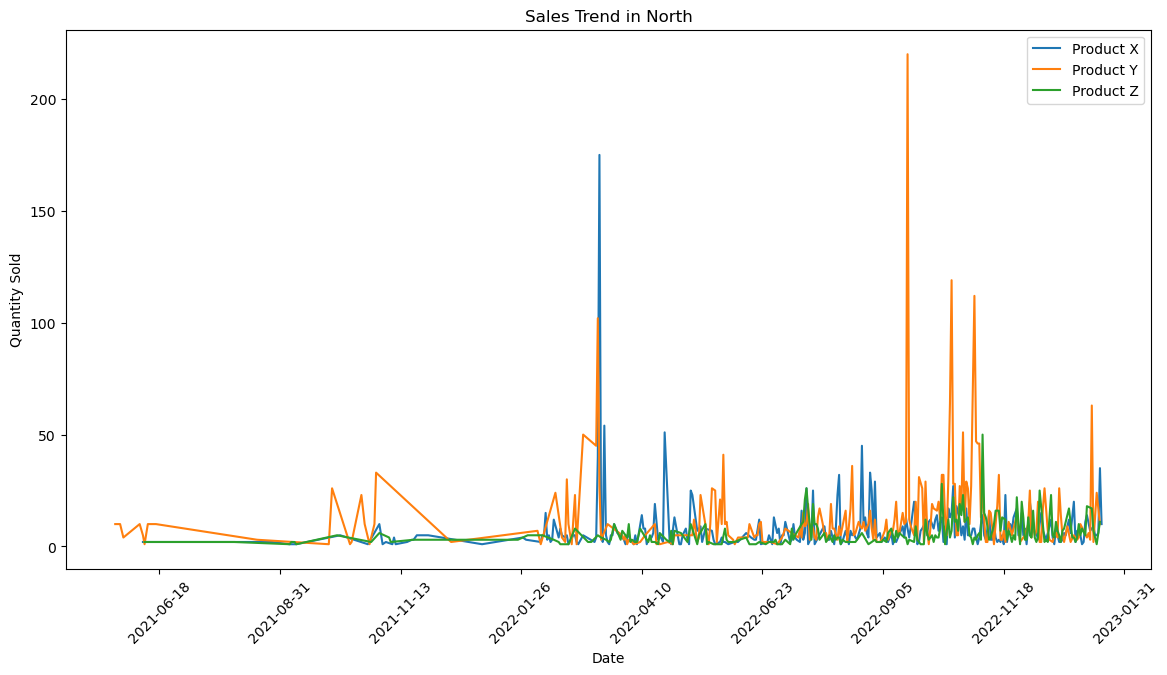

In [24]:
plot_time_series('North')

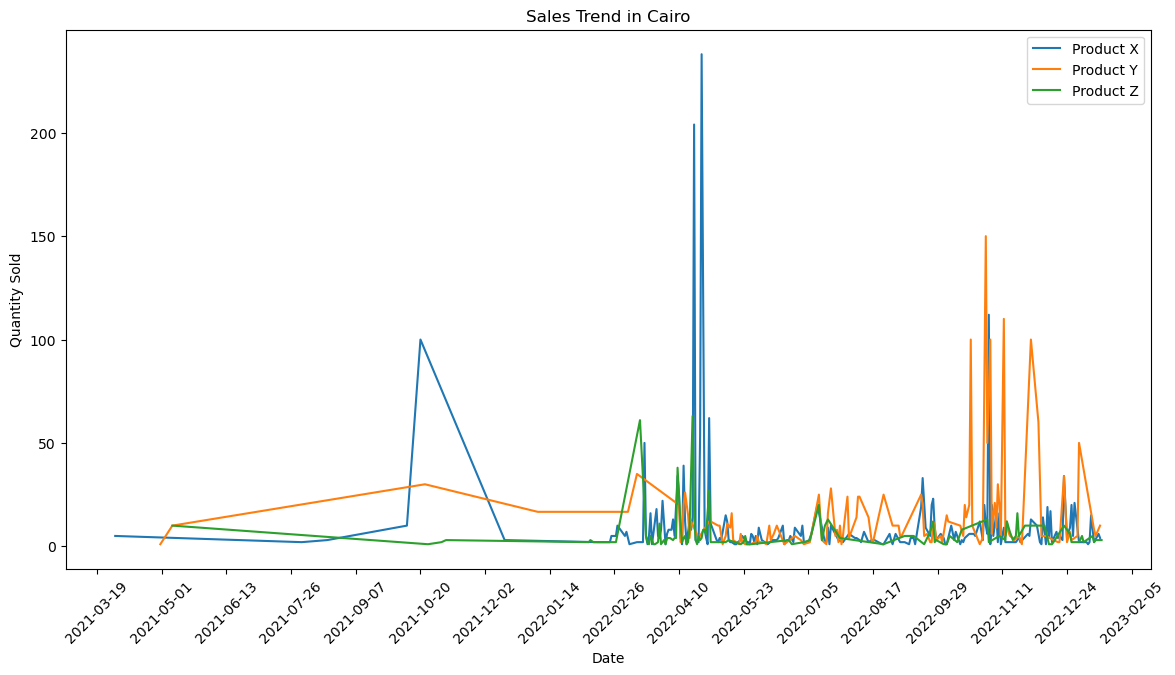

In [25]:
plot_time_series('Cairo')

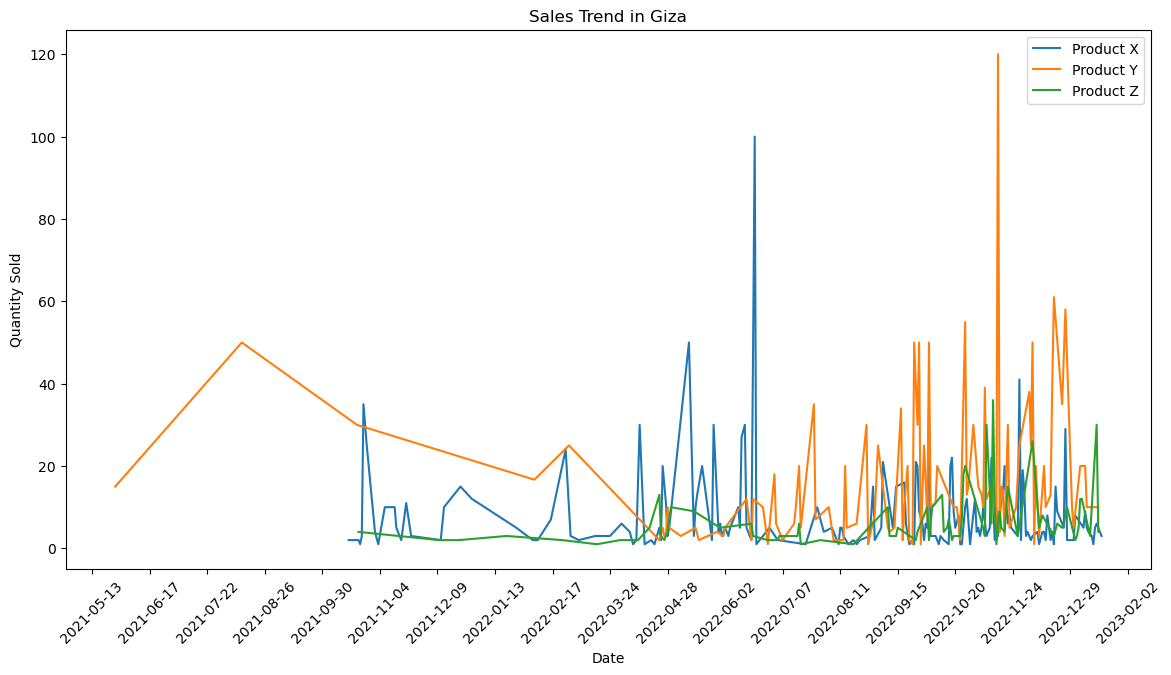

In [26]:
plot_time_series('Giza')

### Training and Forecasting

For this task we will be using pmdarima's auto_arima, which essentialy tries out multiple SARIMA models with different seasonalities, to find the best SARIMA model for the given data, because our data differs from product to product and from city to city

#### Visualizing Trends for product x

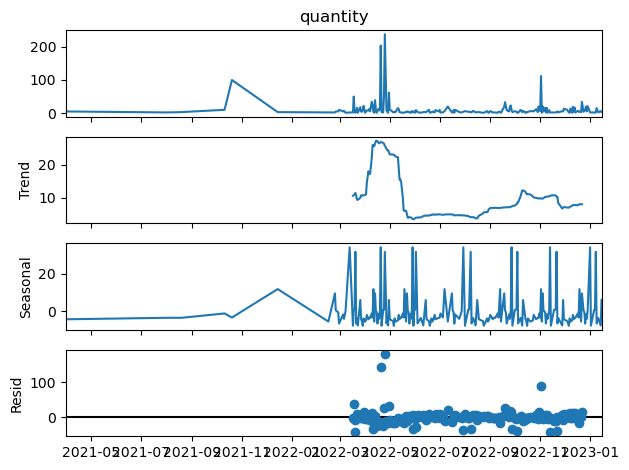

In [27]:
decomposition = seasonal_decompose(df[(df['product_name']=='product x') & (df['city']=='Cairo')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

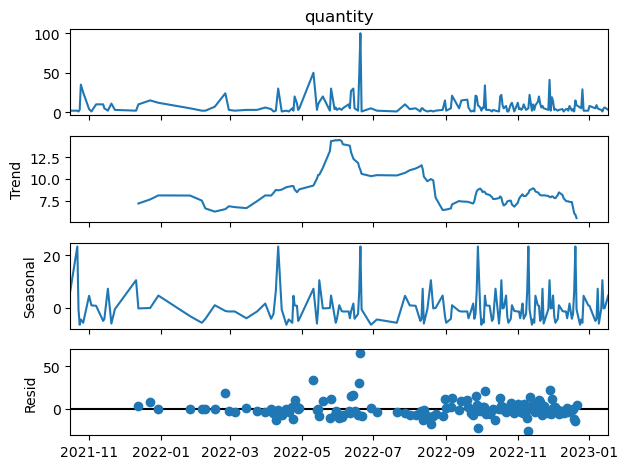

In [28]:
decomposition = seasonal_decompose(df[(df['product_name']=='product x') & (df['city']=='Giza')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

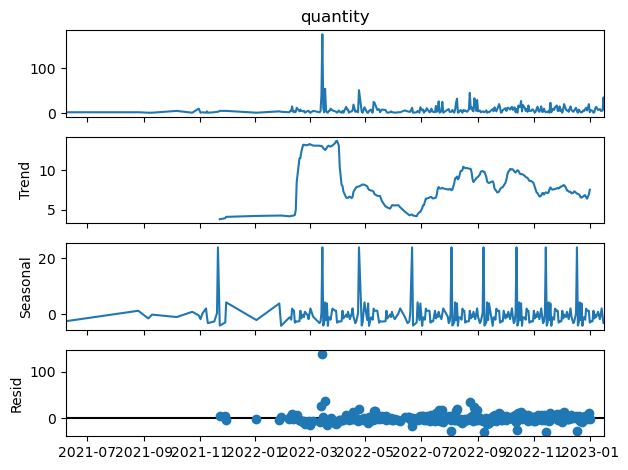

In [29]:
decomposition = seasonal_decompose(df[(df['product_name']=='product x') & (df['city']=='North')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

#### Visualizing trends for product y

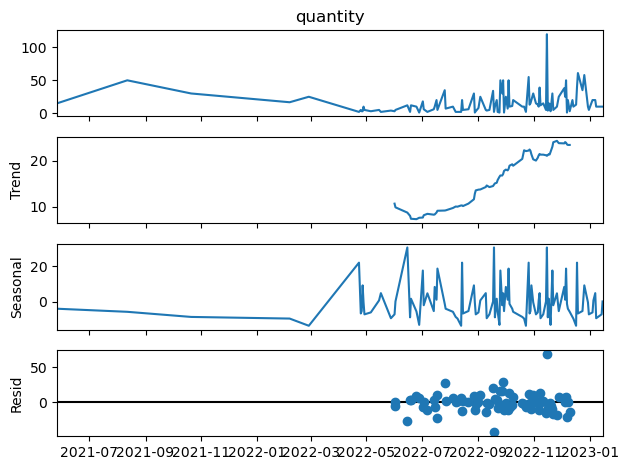

In [30]:
decomposition = seasonal_decompose(df[(df['product_name']=='product y') & (df['city']=='Giza')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

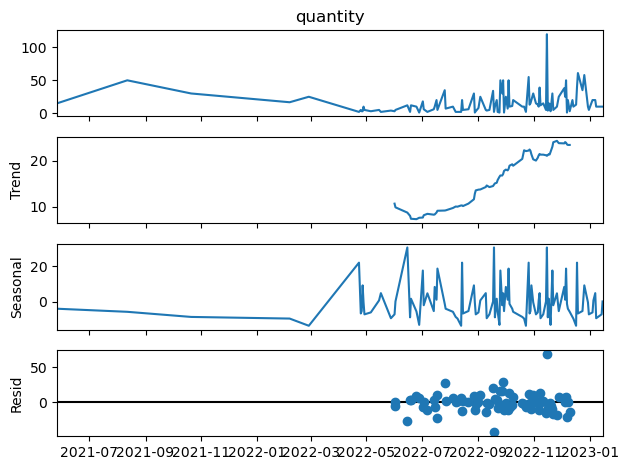

In [31]:
decomposition = seasonal_decompose(df[(df['product_name']=='product y') & (df['city']=='Giza')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

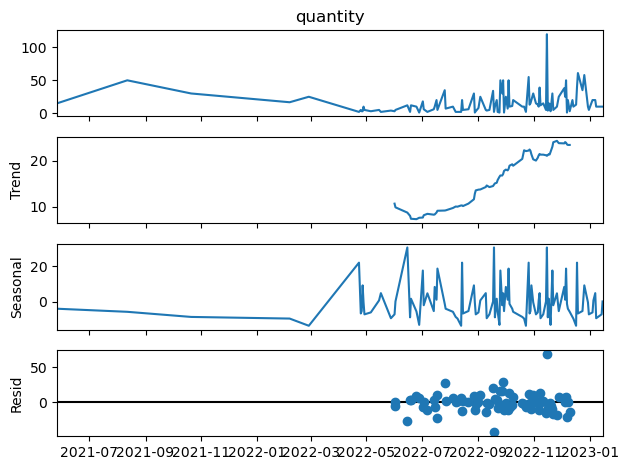

In [32]:
decomposition = seasonal_decompose(df[(df['product_name']=='product y') & (df['city']=='Giza')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

####  Visualizing trends for product z

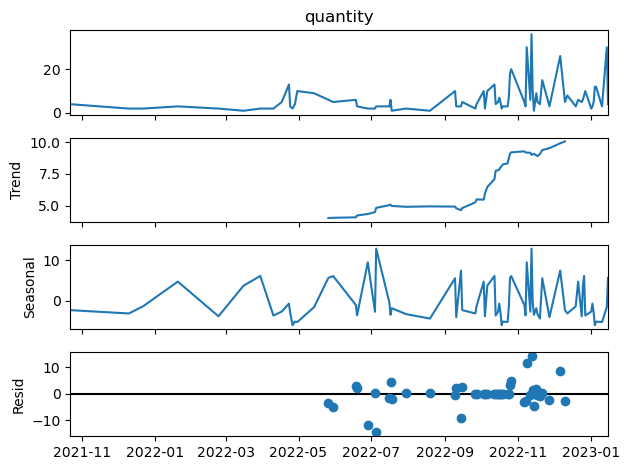

In [33]:
decomposition = seasonal_decompose(df[(df['product_name']=='product z') & (df['city']=='Giza')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

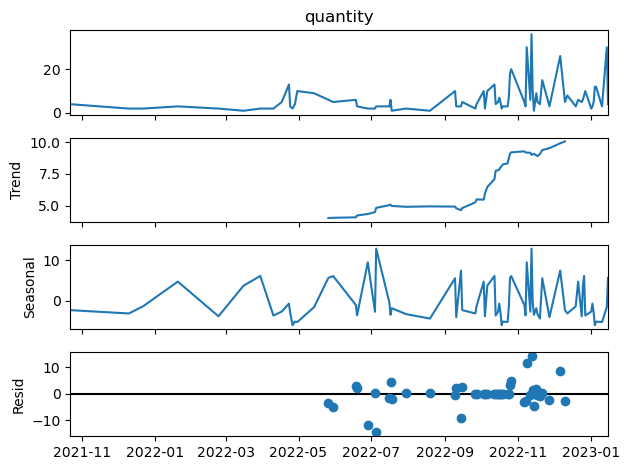

In [34]:
decomposition = seasonal_decompose(df[(df['product_name']=='product z') & (df['city']=='Giza')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

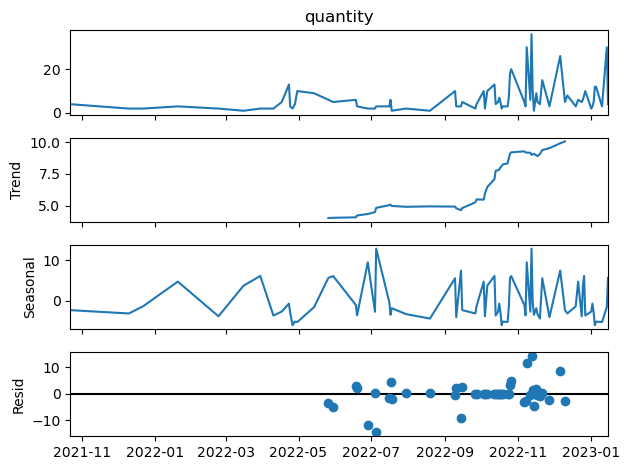

In [35]:
decomposition = seasonal_decompose(df[(df['product_name']=='product z') & (df['city']=='Giza')]['quantity'], model='additive', period=30)
decomposition.plot()
plt.show()

### Model Training & Evaluation

#### Training Model for Each City & Product Combination for Evaluation

In [36]:
def train_predict_evaluate(df, city, product_name):
    filtered_df = df[(df['product_name'] == product_name) & (df['city'] == city)]
    filtered_df = filtered_df.resample('D').interpolate(method='linear')
    y = filtered_df['revenue']
    train = y[:-10]  # Training data
    test = y[-10:]   # Testing data
    
    print("Training data length:", str(len(train)))
    print("Testing data length", str(len(test)))
    model = pm.auto_arima(train, seasonal=True, m=30, trace=True)
    print(model.summary())
    forecast, conf_int = model.predict(n_periods=10, return_conf_int=True)
    mae = mean_absolute_error(test, forecast)
    mape = mean_absolute_percentage_error(test, forecast) * 100
    rmse = mean_squared_error(test, forecast, squared=False)
    
    print(f'----------For {product_name} in {city}----------')
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
    
    # Plotting
    plt.figure(figsize=(8, 4))
    plt.plot(train[-60:].index, train[-60:], label='Training Data', color='blue')
    extended_test = pd.Series([train[-1]] + test.tolist(), 
                              index=[train.index[-1]] + list(test.index))
    plt.plot(extended_test.index, extended_test, label='Actual Data', color='orange')
    extended_forecast = pd.Series([train[-1]] + forecast.tolist(), 
                                  index=[train.index[-1]] + list(test.index))
    plt.plot(extended_forecast.index, extended_forecast, label='Forecast', color='green')
    plt.title(f'Forecast for {product_name} in {city}')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    # Adjust x-axis ticks for readability
    num_ticks = len(filtered_df)
    step = max(1, num_ticks // 10)
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30))
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train, test, forecast, conf_int

Training data length: 646
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=55.83 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=11203.881, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=10814.624, Time=2.67 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=10948.482, Time=5.63 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=11350.717, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=10813.329, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=10814.561, Time=1.74 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=10816.554, Time=3.93 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=10797.248, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[30] intercept   : AIC=10798.694, Time=3.85 sec
 ARIMA(2,0,0)(0,0,1)[30] intercept   : AIC=10798.655, Time=2.44 sec
 ARIMA(2,0,0)(1,0,1)[30] intercept   : AIC=10800.647, Time=4.95 sec
 ARIMA(3,0,0)(0,0,0)[30] intercept   : AIC=10777.208, Time=0.06 sec
 ARIMA(3,0,0)(1,0,0)[30] inte

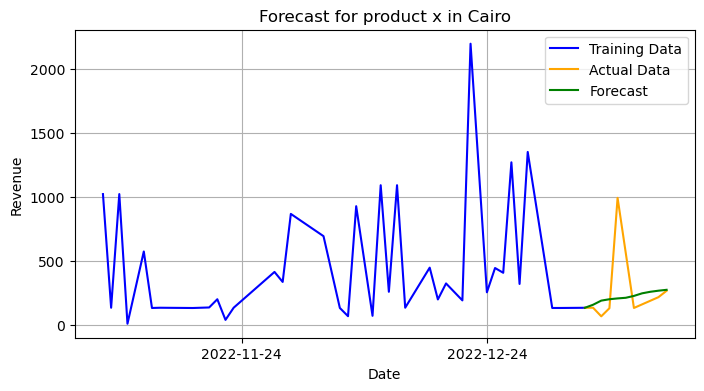

In [37]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'Cairo', 'product x')

Training data length: 616
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=31.41 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=9361.591, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8864.254, Time=2.57 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=9044.571, Time=5.36 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=9359.593, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=8862.260, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=8864.254, Time=1.97 sec
 ARIMA(1,1,0)(1,0,1)[30] intercept   : AIC=inf, Time=11.83 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=8860.669, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[30] intercept   : AIC=8862.668, Time=3.51 sec
 ARIMA(2,1,0)(0,0,1)[30] intercept   : AIC=8862.668, Time=2.76 sec
 ARIMA(2,1,0)(1,0,1)[30] intercept   : AIC=inf, Time=20.20 sec
 ARIMA(3,1,0)(0,0,0)[30] intercept   : AIC=8862.640, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=8862.6

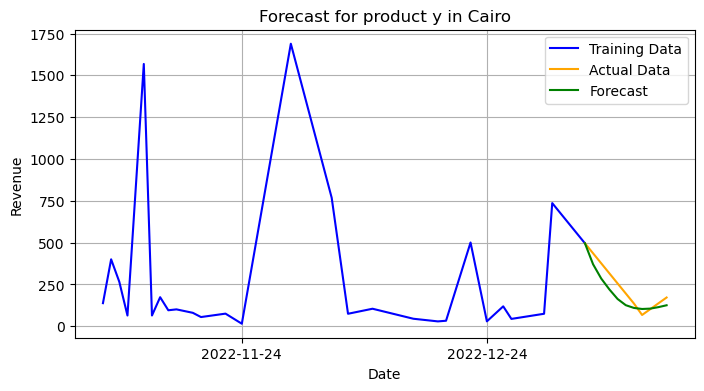

In [38]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'Cairo', 'product y')

Training data length: 609
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=7500.976, Time=20.53 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=8389.464, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=7510.692, Time=2.75 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=7887.910, Time=8.61 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=8672.479, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=7498.716, Time=20.80 sec
 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=7497.112, Time=0.40 sec
 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=7498.723, Time=22.87 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=7496.495, Time=0.17 sec
 ARIMA(1,0,2)(1,0,0)[30] intercept   : AIC=7497.996, Time=12.68 sec
 ARIMA(1,0,2)(0,0,1)[30] intercept   : AIC=7498.007, Time=8.91 sec
 ARIMA(1,0,2)(1,0,1)[30] intercept   : AIC=7499.975, Time=14.42 sec
 ARIMA(0,0,2)(0,0,0)[30] intercept   : AIC=7679.002, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[30] interce

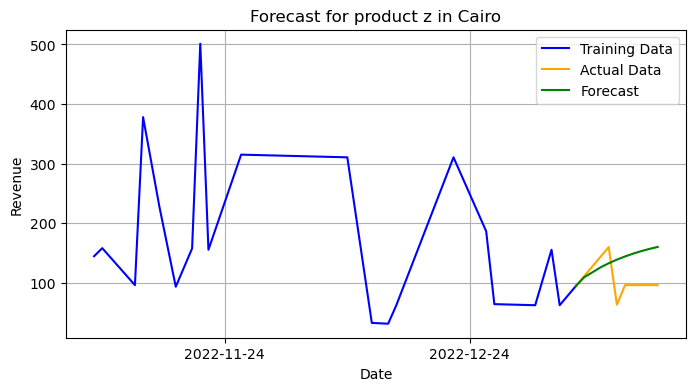

In [39]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'Cairo', 'product z')

Training data length: 579
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=29.11 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=9195.465, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=9122.752, Time=2.05 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=8961.920, Time=8.83 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=9193.467, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=8960.460, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=8961.944, Time=6.75 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=19.01 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=9120.883, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=8920.494, Time=0.42 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=8922.434, Time=13.91 sec
 ARIMA(1,1,2)(0,0,1)[30] intercept   : AIC=8922.432, T

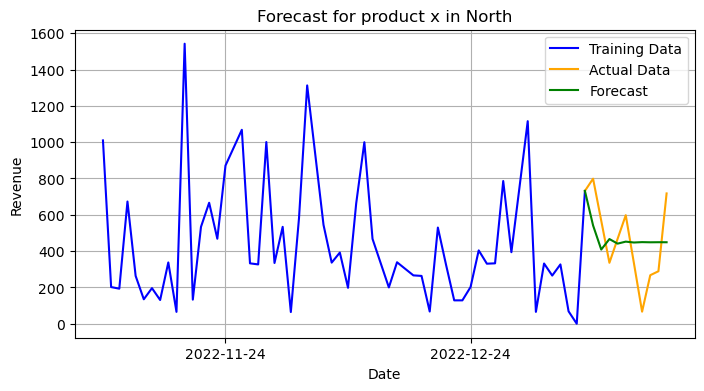

In [40]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'North', 'product x')

Training data length: 595
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=25.35 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=7945.340, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=7819.795, Time=2.30 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=7856.397, Time=7.91 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=8211.250, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=7818.133, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=7819.665, Time=1.67 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=7821.630, Time=3.79 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=7806.048, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[30] intercept   : AIC=7807.580, Time=3.33 sec
 ARIMA(2,0,0)(0,0,1)[30] intercept   : AIC=7807.457, Time=2.12 sec
 ARIMA(2,0,0)(1,0,1)[30] intercept   : AIC=7809.418, Time=4.78 sec
 ARIMA(3,0,0)(0,0,0)[30] intercept   : AIC=7803.213, Time=0.05 sec
 ARIMA(3,0,0)(1,0,0)[30] intercept   : AI

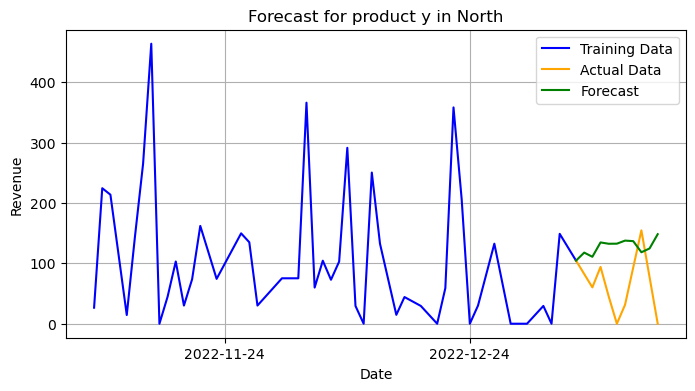

In [41]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'North', 'product y')

Training data length: 577
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=7081.336, Time=28.94 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=7267.885, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=7204.875, Time=4.69 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=7115.568, Time=6.19 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=7265.886, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=7079.812, Time=20.42 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=7083.264, Time=0.38 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=7080.889, Time=134.07 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=7079.478, Time=20.08 sec
 ARIMA(2,1,2)(2,0,0)[30] intercept   : AIC=7081.211, Time=93.14 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=7082.170, Time=165.18 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=7078.091, Time=13.32 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=7081.664, Time=0.32 sec
 ARIMA(1,1,2)(2,0,0)[30] int

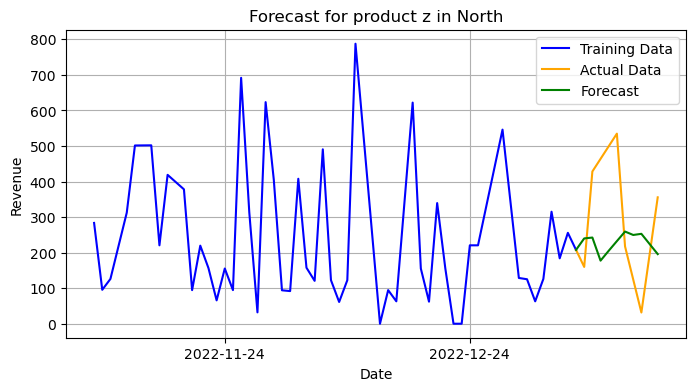

In [42]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'North', 'product z')

Training data length: 449
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=20.25 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=7021.161, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=6839.509, Time=1.89 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=6881.289, Time=6.97 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=7269.710, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=6837.525, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=6839.509, Time=1.47 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=6841.508, Time=3.10 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=6839.526, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=6839.532, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=6879.302, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=6841.527, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[30]             : AIC=6884.041, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[30] int

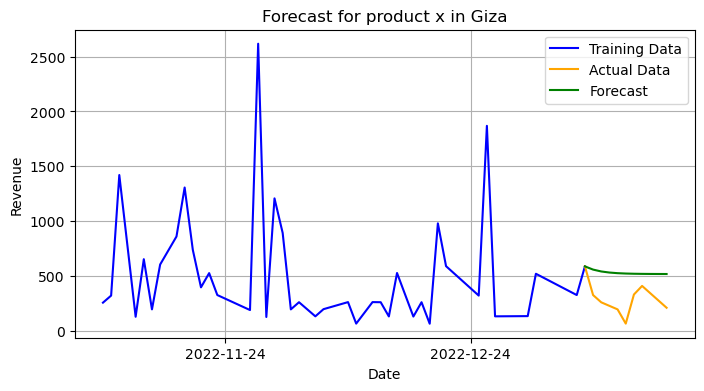

In [43]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'Giza', 'product x')

Training data length: 589
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=25.16 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=9522.226, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8588.895, Time=2.97 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=9125.448, Time=6.41 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=9520.227, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=8587.090, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=8588.883, Time=2.27 sec
 ARIMA(1,1,0)(1,0,1)[30] intercept   : AIC=8590.227, Time=5.83 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=8518.191, Time=0.06 sec
 ARIMA(2,1,0)(1,0,0)[30] intercept   : AIC=8520.121, Time=4.63 sec
 ARIMA(2,1,0)(0,0,1)[30] intercept   : AIC=8520.120, Time=3.84 sec
 ARIMA(2,1,0)(1,0,1)[30] intercept   : AIC=8521.919, Time=13.33 sec
 ARIMA(3,1,0)(0,0,0)[30] intercept   : AIC=8519.725, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : A

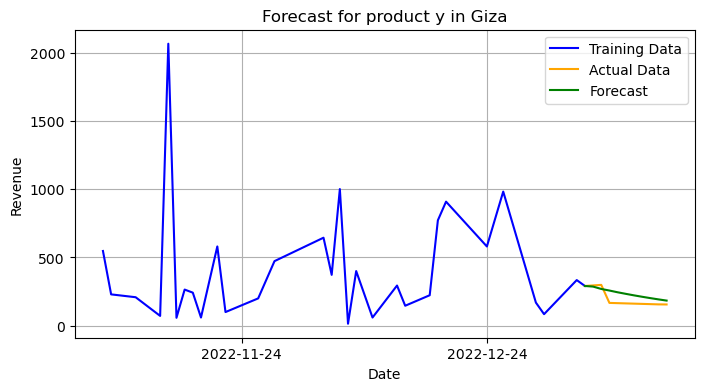

In [44]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'Giza', 'product y')

Training data length: 441
Testing data length 10
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=5029.231, Time=25.59 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=5097.013, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=5088.553, Time=3.20 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=5082.606, Time=3.17 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=5095.034, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=5025.900, Time=19.49 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=5028.088, Time=0.33 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=5027.835, Time=127.28 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=5026.009, Time=19.50 sec
 ARIMA(2,1,2)(1,0,2)[30] intercept   : AIC=5029.436, Time=155.44 sec
 ARIMA(1,1,2)(0,0,1)[30] intercept   : AIC=5051.442, Time=13.28 sec
 ARIMA(2,1,1)(0,0,1)[30] intercept   : AIC=5051.487, Time=12.68 sec
 ARIMA(3,1,2)(0,0,1)[30] intercept   : AIC=5013.201, Time=10.51 sec
 ARIMA(3,1,2)(0,0,0)[30] in

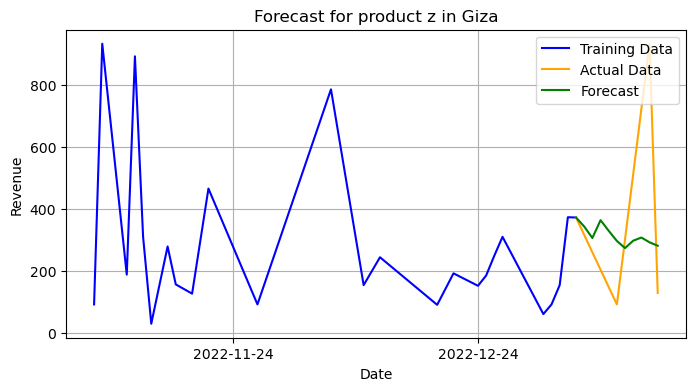

In [45]:
train, test, forecast, conf_int = train_predict_evaluate(df, 'Giza', 'product z')

#### Train Model for Forecasting Next 10 Days

In [46]:
results_df = pd.DataFrame()

In [47]:
def train_model_for_forecasting(df, city, product_name):
    filtered_df = df[(df['product_name'] == product_name) & (df['city'] == city)]
    filtered_df = filtered_df.resample('D').interpolate(method='linear')
    y = filtered_df['revenue']
    train = y 
    model = pm.auto_arima(train, seasonal=True, m=30, trace=True)
    # print(model.summary())
    return model

def predict_forecast(model, df, city, product_name):
    filtered_df = df[(df['product_name'] == product_name) & (df['city'] == city)]
    filtered_df = filtered_df.resample('D').interpolate(method='linear')
    train = filtered_df['revenue']
    last_date = train.index[-1]
    next_10_days = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=10)
    forecast, conf_int = model.predict(n_periods=10, return_conf_int=True)
    forecast_df = pd.DataFrame({
        'date': next_10_days,
        'forecast': forecast.values,
        'city': city,
        'product': product_name
    })
    total_sum = round(forecast_df['forecast'].sum(), 2)
    total_row = pd.DataFrame({
        'date': ['total'],
        'forecast': [total_sum],
        'city': city,
        'product': product_name
    })
    forecast_df = pd.concat([forecast_df, total_row], ignore_index=True)
    plt.figure(figsize=(8, 4))
    plt.plot(train[-60:].index, train[-60:], label='Training Data', color='blue')
    extended_forecast = pd.Series([train[-1]] + forecast.tolist(), 
                                  index=[train.index[-1]] + list(next_10_days))
    plt.plot(extended_forecast.index, extended_forecast, label='Forecast', color='green')
    plt.title(f'Forecast for {product_name} in {city}')
    plt.xlabel('Date')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.show()
    return forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=30.14 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=11368.494, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=10972.790, Time=3.01 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=11108.809, Time=7.41 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=11516.941, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=10971.484, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=10972.728, Time=2.00 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=10974.720, Time=4.55 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=10955.159, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[30] intercept   : AIC=10956.619, Time=5.93 sec
 ARIMA(2,0,0)(0,0,1)[30] intercept   : AIC=10956.580, Time=3.77 sec
 ARIMA(2,0,0)(1,0,1)[30] intercept   : AIC=10958.572, Time=5.84 sec
 ARIMA(3,0,0)(0,0,0)[30] intercept   : AIC=10934.710, Time=0.08 sec
 ARIMA(3,0,0)(1,0,0)[30] intercept   : AIC=10936.669, Time=5.87 sec
 ARIMA(3,0

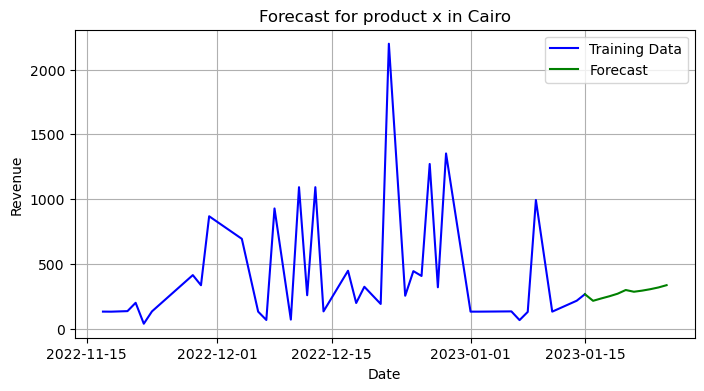

,date,forecast,city,product
0,2023-01-16 00:00:00+00:00,214.407479,Cairo,product x
1,2023-01-17 00:00:00+00:00,232.559090,Cairo,product x
2,2023-01-18 00:00:00+00:00,249.598638,Cairo,product x
3,2023-01-19 00:00:00+00:00,269.065893,Cairo,product x
4,2023-01-20 00:00:00+00:00,297.750059,Cairo,product x
5,2023-01-21 00:00:00+00:00,284.337506,Cairo,product x
6,2023-01-22 00:00:00+00:00,292.895266,Cairo,product x
7,2023-01-23 00:00:00+00:00,303.951757,Cairo,product x
8,2023-01-24 00:00:00+00:00,317.426308,Cairo,product x
9,2023-01-25 00:00:00+00:00,335.133495,Cairo,product x


In [48]:
model = train_model_for_forecasting(df, 'Cairo', 'product x')
forecast_df = predict_forecast(model, df, 'Cairo', 'product x')
forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=8980.577, Time=33.70 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=9503.795, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8998.259, Time=3.13 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=9181.640, Time=7.30 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=9501.796, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=8979.348, Time=15.13 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=8977.429, Time=0.27 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=8979.338, Time=15.50 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=8996.038, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=8996.620, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[30] intercept   : AIC=8942.460, Time=0.73 sec
 ARIMA(3,1,2)(1,0,0)[30] intercept   : AIC=8944.297, Time=33.87 sec
 ARIMA(3,1,2)(0,0,1)[30] intercept   : AIC=8944.311, Time=28.89 sec
 ARIMA(3,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=32.64 sec
 ARIMA(3,1,1)(0,0,

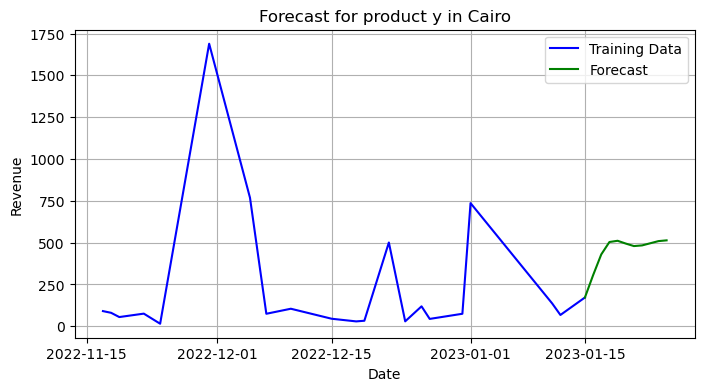

,date,forecast,city,product
0,2023-01-16 00:00:00+00:00,304.635239,Cairo,product y
1,2023-01-17 00:00:00+00:00,429.154929,Cairo,product y
2,2023-01-18 00:00:00+00:00,503.418027,Cairo,product y
3,2023-01-19 00:00:00+00:00,510.798880,Cairo,product y
4,2023-01-20 00:00:00+00:00,494.168608,Cairo,product y
5,2023-01-21 00:00:00+00:00,479.144504,Cairo,product y
6,2023-01-22 00:00:00+00:00,483.132727,Cairo,product y
7,2023-01-23 00:00:00+00:00,495.927351,Cairo,product y
8,2023-01-24 00:00:00+00:00,508.788775,Cairo,product y
9,2023-01-25 00:00:00+00:00,513.341668,Cairo,product y


In [49]:
model = train_model_for_forecasting(df, 'Cairo', 'product y')
forecast_df = predict_forecast(model, df, 'Cairo', 'product y')
forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=7614.771, Time=17.57 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=8518.190, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=7624.689, Time=2.85 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=8008.277, Time=8.23 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=8806.186, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[30] intercept   : AIC=7612.512, Time=20.96 sec
 ARIMA(2,0,2)(0,0,0)[30] intercept   : AIC=7610.884, Time=0.35 sec
 ARIMA(2,0,2)(1,0,0)[30] intercept   : AIC=7612.519, Time=22.69 sec
 ARIMA(1,0,2)(0,0,0)[30] intercept   : AIC=7610.296, Time=0.12 sec
 ARIMA(1,0,2)(1,0,0)[30] intercept   : AIC=7611.823, Time=14.20 sec
 ARIMA(1,0,2)(0,0,1)[30] intercept   : AIC=7611.834, Time=8.92 sec
 ARIMA(1,0,2)(1,0,1)[30] intercept   : AIC=7613.802, Time=11.80 sec
 ARIMA(0,0,2)(0,0,0)[30] intercept   : AIC=7796.061, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=7611.207, Time=0.17 sec
 ARIMA(1,0,3)(

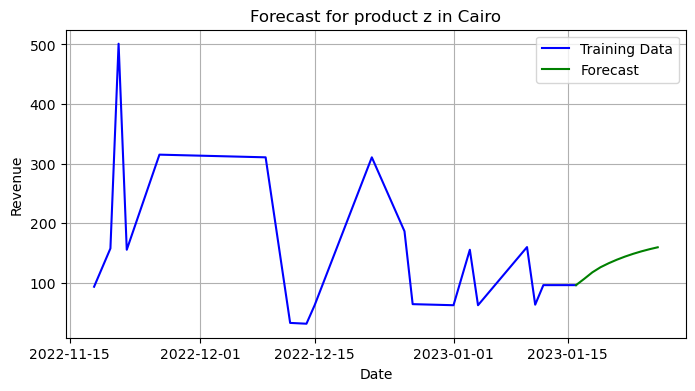

,date,forecast,city,product
0,2023-01-17 00:00:00+00:00,106.389286,Cairo,product z
1,2023-01-18 00:00:00+00:00,117.358001,Cairo,product z
2,2023-01-19 00:00:00+00:00,125.926086,Cairo,product z
3,2023-01-20 00:00:00+00:00,132.637933,Cairo,product z
4,2023-01-21 00:00:00+00:00,138.573188,Cairo,product z
5,2023-01-22 00:00:00+00:00,143.821706,Cairo,product z
6,2023-01-23 00:00:00+00:00,148.462946,Cairo,product z
7,2023-01-24 00:00:00+00:00,152.567171,Cairo,product z
8,2023-01-25 00:00:00+00:00,156.196519,Cairo,product z
9,2023-01-26 00:00:00+00:00,159.405934,Cairo,product z


In [50]:
model = train_model_for_forecasting(df, 'Cairo', 'product z')
forecast_df = predict_forecast(model, df, 'Cairo', 'product z')
forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=24.08 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=7169.349, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=6982.618, Time=2.46 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=7025.795, Time=9.24 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=7422.745, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=6980.627, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=6982.618, Time=1.44 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=6984.618, Time=3.50 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=6982.629, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[30] intercept   : AIC=6982.636, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[30] intercept   : AIC=7023.828, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[30] intercept   : AIC=6984.628, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[30]             : AIC=7027.638, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[30] intercept
Total fit time: 41.157 seconds


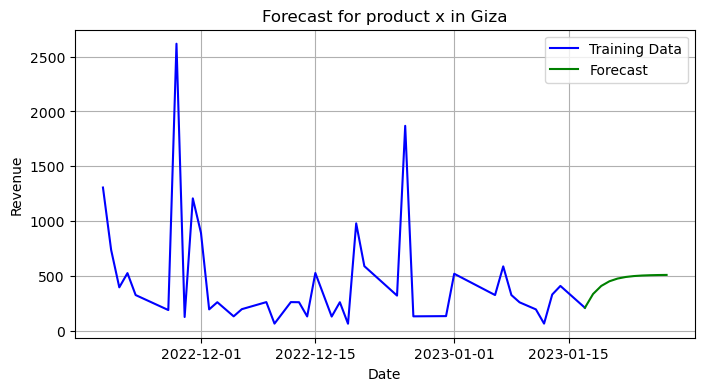

,date,forecast,city,product
0,2023-01-18 00:00:00+00:00,336.542648,Giza,product x
1,2023-01-19 00:00:00+00:00,409.681233,Giza,product x
2,2023-01-20 00:00:00+00:00,452.246204,Giza,product x
3,2023-01-21 00:00:00+00:00,477.018036,Giza,product x
4,2023-01-22 00:00:00+00:00,491.434671,Giza,product x
5,2023-01-23 00:00:00+00:00,499.824820,Giza,product x
6,2023-01-24 00:00:00+00:00,504.707694,Giza,product x
7,2023-01-25 00:00:00+00:00,507.549414,Giza,product x
8,2023-01-26 00:00:00+00:00,509.203229,Giza,product x
9,2023-01-27 00:00:00+00:00,510.165712,Giza,product x


In [51]:
model = train_model_for_forecasting(df, 'Giza', 'product x')
forecast_df = predict_forecast(model, df, 'Giza', 'product x')
forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=24.54 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=9674.044, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=8725.008, Time=2.85 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=9270.552, Time=5.75 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=9672.045, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=8723.195, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[30] intercept   : AIC=8724.997, Time=2.40 sec
 ARIMA(1,1,0)(1,0,1)[30] intercept   : AIC=8726.390, Time=6.35 sec
 ARIMA(2,1,0)(0,0,0)[30] intercept   : AIC=8653.054, Time=0.05 sec
 ARIMA(2,1,0)(1,0,0)[30] intercept   : AIC=8654.987, Time=4.13 sec
 ARIMA(2,1,0)(0,0,1)[30] intercept   : AIC=8654.985, Time=3.83 sec
 ARIMA(2,1,0)(1,0,1)[30] intercept   : AIC=8656.796, Time=11.21 sec
 ARIMA(3,1,0)(0,0,0)[30] intercept   : AIC=8654.573, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[30] intercept   : AIC=8654.724, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[3

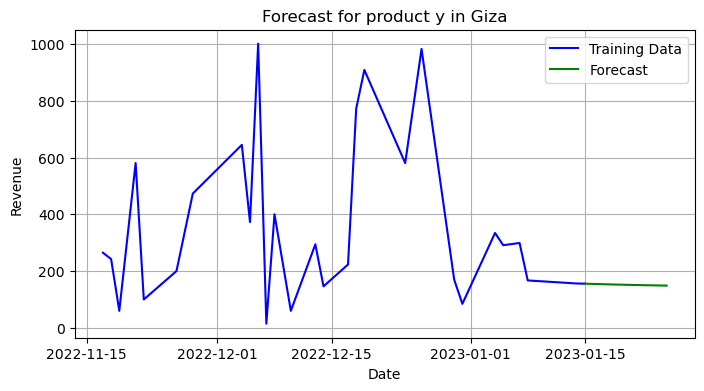

,date,forecast,city,product
0,2023-01-16 00:00:00+00:00,154.839354,Giza,product y
1,2023-01-17 00:00:00+00:00,154.069612,Giza,product y
2,2023-01-18 00:00:00+00:00,153.291261,Giza,product y
3,2023-01-19 00:00:00+00:00,152.572099,Giza,product y
4,2023-01-20 00:00:00+00:00,151.885019,Giza,product y
5,2023-01-21 00:00:00+00:00,151.236827,Giza,product y
6,2023-01-22 00:00:00+00:00,150.622420,Giza,product y
7,2023-01-23 00:00:00+00:00,150.041071,Giza,product y
8,2023-01-24 00:00:00+00:00,149.490635,Giza,product y
9,2023-01-25 00:00:00+00:00,148.969599,Giza,product y


In [52]:
model = train_model_for_forecasting(df, 'Giza', 'product y')
forecast_df = predict_forecast(model, df, 'Giza', 'product y')
forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=5269.209, Time=21.84 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=5322.152, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=5317.077, Time=3.04 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=5310.598, Time=3.04 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=5320.152, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=5267.503, Time=16.39 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=5267.092, Time=0.25 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=5267.619, Time=15.51 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=5265.230, Time=0.19 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=5265.892, Time=9.58 sec
 ARIMA(1,1,2)(0,0,1)[30] intercept   : AIC=5265.839, Time=11.70 sec
 ARIMA(1,1,2)(1,0,1)[30] intercept   : AIC=5267.769, Time=16.41 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=5290.512, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=5265.087, Time=0.14 sec
 ARIMA(1,1,1)(

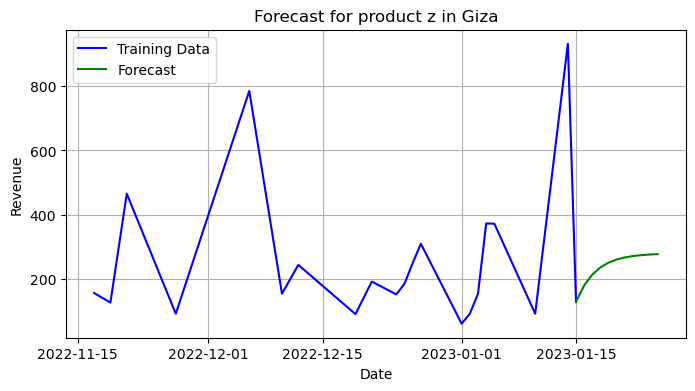

,date,forecast,city,product
0,2023-01-16 00:00:00+00:00,181.193609,Giza,product z
1,2023-01-17 00:00:00+00:00,214.954344,Giza,product z
2,2023-01-18 00:00:00+00:00,237.240359,Giza,product z
3,2023-01-19 00:00:00+00:00,251.951723,Giza,product z
4,2023-01-20 00:00:00+00:00,261.662935,Giza,product z
5,2023-01-21 00:00:00+00:00,268.073466,Giza,product z
6,2023-01-22 00:00:00+00:00,272.305162,Giza,product z
7,2023-01-23 00:00:00+00:00,275.098575,Giza,product z
8,2023-01-24 00:00:00+00:00,276.942552,Giza,product z
9,2023-01-25 00:00:00+00:00,278.159791,Giza,product z


In [53]:
model = train_model_for_forecasting(df, 'Giza', 'product z')
forecast_df = predict_forecast(model, df, 'Giza', 'product z')
forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=inf, Time=28.70 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=9345.504, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=9271.975, Time=1.86 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=9108.280, Time=8.60 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=9343.507, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[30] intercept   : AIC=9106.840, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[30] intercept   : AIC=9108.303, Time=5.76 sec
 ARIMA(0,1,1)(1,0,1)[30] intercept   : AIC=inf, Time=22.72 sec
 ARIMA(1,1,1)(0,0,0)[30] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[30] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[30] intercept   : AIC=9270.135, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=9065.950, Time=0.26 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=9067.882, Time=14.42 sec
 ARIMA(1,1,2)(0,0,1)[30] intercept   : AIC=9067.880, Time=18.94 sec
 ARIMA(1,1,2)(1,0,1)[30] intercept 

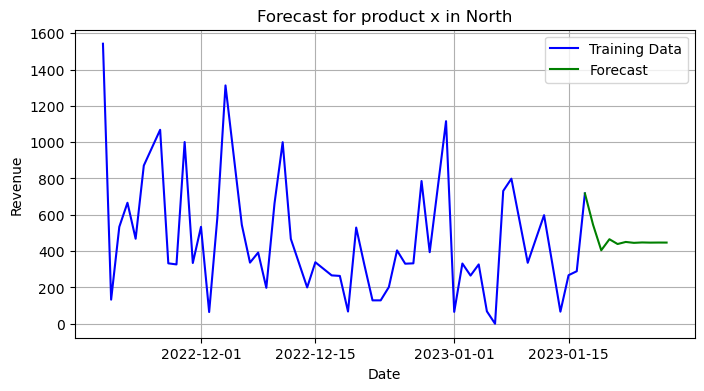

,date,forecast,city,product
0,2023-01-18 00:00:00+00:00,544.941518,North,product x
1,2023-01-19 00:00:00+00:00,404.592942,North,product x
2,2023-01-20 00:00:00+00:00,465.425154,North,product x
3,2023-01-21 00:00:00+00:00,439.058246,North,product x
4,2023-01-22 00:00:00+00:00,450.486629,North,product x
5,2023-01-23 00:00:00+00:00,445.533149,North,product x
6,2023-01-24 00:00:00+00:00,447.680169,North,product x
7,2023-01-25 00:00:00+00:00,446.749572,North,product x
8,2023-01-26 00:00:00+00:00,447.152927,North,product x
9,2023-01-27 00:00:00+00:00,446.978098,North,product x


In [54]:
model = train_model_for_forecasting(df, 'North', 'product x')
forecast_df = predict_forecast(model, df, 'North', 'product x')
forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[30] intercept   : AIC=inf, Time=25.55 sec
 ARIMA(0,0,0)(0,0,0)[30] intercept   : AIC=8071.049, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[30] intercept   : AIC=7942.465, Time=2.10 sec
 ARIMA(0,0,1)(0,0,1)[30] intercept   : AIC=7980.003, Time=7.83 sec
 ARIMA(0,0,0)(0,0,0)[30]             : AIC=8340.211, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[30] intercept   : AIC=7940.814, Time=0.03 sec
 ARIMA(1,0,0)(0,0,1)[30] intercept   : AIC=7942.334, Time=1.64 sec
 ARIMA(1,0,0)(1,0,1)[30] intercept   : AIC=7944.300, Time=3.92 sec
 ARIMA(2,0,0)(0,0,0)[30] intercept   : AIC=7928.501, Time=0.03 sec
 ARIMA(2,0,0)(1,0,0)[30] intercept   : AIC=7930.006, Time=2.98 sec
 ARIMA(2,0,0)(0,0,1)[30] intercept   : AIC=7929.882, Time=2.22 sec
 ARIMA(2,0,0)(1,0,1)[30] intercept   : AIC=7931.845, Time=4.99 sec
 ARIMA(3,0,0)(0,0,0)[30] intercept   : AIC=7925.530, Time=0.04 sec
 ARIMA(3,0,0)(1,0,0)[30] intercept   : AIC=7926.257, Time=4.94 sec
 ARIMA(3,0,0)(0,0,1)[30

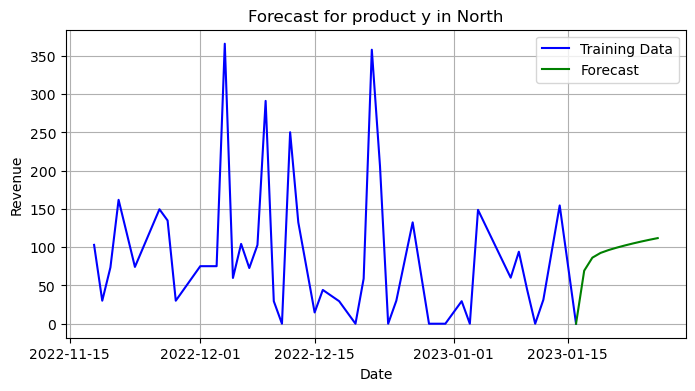

,date,forecast,city,product
0,2023-01-17 00:00:00+00:00,69.330911,North,product y
1,2023-01-18 00:00:00+00:00,86.335994,North,product y
2,2023-01-19 00:00:00+00:00,92.523309,North,product y
3,2023-01-20 00:00:00+00:00,96.329670,North,product y
4,2023-01-21 00:00:00+00:00,99.479773,North,product y
5,2023-01-22 00:00:00+00:00,102.335359,North,product y
6,2023-01-23 00:00:00+00:00,104.980785,North,product y
7,2023-01-24 00:00:00+00:00,107.443374,North,product y
8,2023-01-25 00:00:00+00:00,109.738185,North,product y
9,2023-01-26 00:00:00+00:00,111.877139,North,product y


In [55]:
model = train_model_for_forecasting(df, 'North', 'product y')
forecast_df = predict_forecast(model, df, 'North', 'product y')
forecast_df

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[30] intercept   : AIC=7215.342, Time=25.28 sec
 ARIMA(0,1,0)(0,0,0)[30] intercept   : AIC=7398.130, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[30] intercept   : AIC=7341.789, Time=1.87 sec
 ARIMA(0,1,1)(0,0,1)[30] intercept   : AIC=7257.845, Time=5.87 sec
 ARIMA(0,1,0)(0,0,0)[30]             : AIC=7396.138, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[30] intercept   : AIC=7213.396, Time=22.36 sec
 ARIMA(2,1,2)(0,0,0)[30] intercept   : AIC=7214.136, Time=0.29 sec
 ARIMA(2,1,2)(0,0,2)[30] intercept   : AIC=7215.217, Time=166.75 sec
 ARIMA(2,1,2)(1,0,0)[30] intercept   : AIC=7213.341, Time=20.88 sec
 ARIMA(2,1,2)(2,0,0)[30] intercept   : AIC=7215.332, Time=142.73 sec
 ARIMA(2,1,2)(2,0,1)[30] intercept   : AIC=inf, Time=160.93 sec
 ARIMA(1,1,2)(1,0,0)[30] intercept   : AIC=7211.928, Time=13.26 sec
 ARIMA(1,1,2)(0,0,0)[30] intercept   : AIC=7212.596, Time=0.33 sec
 ARIMA(1,1,2)(2,0,0)[30] intercept   : AIC=7213.913, Time=107.01 sec
 ARIMA(1,1,2

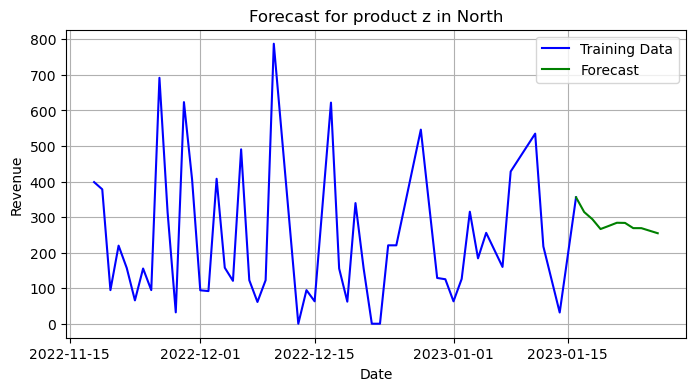

,date,forecast,city,product
0,2023-01-17 00:00:00+00:00,314.002517,North,product z
1,2023-01-18 00:00:00+00:00,293.997256,North,product z
2,2023-01-19 00:00:00+00:00,266.311118,North,product z
3,2023-01-20 00:00:00+00:00,274.988657,North,product z
4,2023-01-21 00:00:00+00:00,283.957211,North,product z
5,2023-01-22 00:00:00+00:00,283.508451,North,product z
6,2023-01-23 00:00:00+00:00,268.847398,North,product z
7,2023-01-24 00:00:00+00:00,268.788588,North,product z
8,2023-01-25 00:00:00+00:00,261.636356,North,product z
9,2023-01-26 00:00:00+00:00,254.497706,North,product z


In [56]:
model = train_model_for_forecasting(df, 'North', 'product z')
forecast_df = predict_forecast(model, df, 'North', 'product z')
forecast_df